# Healthcare Provider Fraud Detection: Data Exploration & Feature Engineering

## Project Overview

Healthcare fraud represents a critical challenge costing the U.S. healthcare system over **$68 billion annually**. This notebook implements comprehensive data exploration and feature engineering for Medicare fraud detection, transforming raw claims data into meaningful provider-level features for machine learning.

### Business Context
The Centers for Medicare & Medicaid Services (CMS) can only investigate a small fraction of suspicious cases due to resource constraints. Traditional rule-based systems capture obvious patterns but fail to identify sophisticated fraud schemes. Our goal is to develop a data-driven approach that identifies high-risk providers while maintaining interpretability.

### Common Fraud Types
- **Billing fraud**: Services never rendered or upcoding procedures
- **Patient fraud**: Claims for deceased patients or phantom beneficiaries  
- **Prescription fraud**: Unnecessary treatments for financial gain
- **Network fraud**: Kickback schemes and improper referrals
- **Temporal fraud**: Unbundling procedures or billing manipulation

## Theoretical Foundation

### 1. Multi-Table Data Integration Strategy

Healthcare data exists at multiple granularities requiring careful aggregation:
- **Beneficiary Level**: Patient demographics, chronic conditions, coverage history
- **Claim Level**: Individual transactions with financial and medical details  
- **Provider Level**: Target unit for fraud prediction

**Challenge**: Transform claim-level transactions into provider-level features while preserving fraud signals.

### 2. Feature Engineering Principles

#### 2.1 Statistical Aggregation
- **Financial Features**: Sum, mean, variance of claim amounts and reimbursements
- **Volume Features**: Claim counts, beneficiary diversity, service frequency
- **Temporal Features**: Claim duration patterns, seasonal variations

#### 2.2 Behavioral Pattern Recognition
- **Network Analysis**: Physician collaborations, referral patterns
- **Medical Diversity**: Diagnosis/procedure code variety and complexity
- **Geographic Patterns**: Multi-state operations, unusual location clustering

#### 2.3 Fraud Indicator Development
Research suggests fraudulent providers exhibit:
- **Abnormal billing patterns**: Excessive claims, unusual amounts
- **Limited medical diversity**: Repetitive procedures, narrow specialization
- **Extended networks**: Unusual physician relationships, geographic spread
- **Temporal anomalies**: Irregular claim timing, suspicious durations

### 3. Data Quality Framework

#### 3.1 Completeness Assessment
- Missing value patterns across datasets
- Temporal coverage consistency
- Cross-table referential integrity

#### 3.2 Consistency Validation
- Data type alignment (dates, currencies, codes)
- Business rule compliance (valid date ranges, logical amounts)
- Cross-dataset relationship verification

#### 3.3 Outlier Detection Strategy
- Statistical outliers (z-score > 3)
- Business logic violations
- Fraud-indicative extreme values vs. data errors

### 4. Exploratory Data Analysis Goals

#### 4.1 Univariate Analysis
- Distribution analysis for each feature type
- Central tendency and spread measurements
- Skewness and kurtosis assessment

#### 4.2 Bivariate Analysis  
- Fraud vs. non-fraud feature comparisons
- Correlation analysis with target variable
- Statistical significance testing

#### 4.3 Multivariate Analysis
- Feature correlation matrices
- Dimensionality assessment
- Interaction effect identification

## Expected Outcomes

This notebook will deliver:
1. **Clean, integrated dataset** ready for machine learning
2. **33 engineered features** across 6 categories 
3. **Comprehensive data quality report** with validation metrics
4. **Fraud pattern insights** from exploratory analysis
5. **Feature correlation analysis** for model preparation

---

## 1. Data Loading and Initial Setup

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Load all datasets
try:
    beneficiary_df = pd.read_csv('../Train_Beneficiarydata-1542865627584.csv')
    inpatient_df = pd.read_csv('../Train_Inpatientdata-1542865627584.csv')
    outpatient_df = pd.read_csv('../Train_Outpatientdata-1542865627584.csv')
    labels_df = pd.read_csv('../Train-1542865627584.csv')
    
    print("✅ All datasets loaded successfully!")
    print(f"Beneficiary data: {beneficiary_df.shape}")
    print(f"Inpatient data: {inpatient_df.shape}")
    print(f"Outpatient data: {outpatient_df.shape}")
    print(f"Labels data: {labels_df.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    print("Please ensure CSV files are in the parent directory")

✅ All datasets loaded successfully!
Beneficiary data: (138556, 25)
Inpatient data: (40474, 30)
Outpatient data: (517737, 27)
Labels data: (5410, 2)


## 2. Data Understanding and Quality Assessment

In [3]:
# Data quality summary function
def data_quality_summary(df, name):
    print(f"\n=== {name} Dataset Quality Report ===")
    print(f"Shape: {df.shape}")
    print(f"Missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate rows: {df.duplicated().sum()}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values by column
    missing = df.isnull().sum()
    if missing.sum() > 0:
        missing_pct = (missing / len(df)) * 100
        missing_summary = pd.DataFrame({
            'Missing_Count': missing[missing > 0],
            'Missing_Percentage': missing_pct[missing_pct > 0]
        }).round(2)
        print("\nColumns with missing values:")
        print(missing_summary.head(10))

# Generate quality reports for all datasets
for df, name in [(beneficiary_df, 'Beneficiary'), (inpatient_df, 'Inpatient'), 
                 (outpatient_df, 'Outpatient'), (labels_df, 'Labels')]:
    data_quality_summary(df, name)


=== Beneficiary Dataset Quality Report ===
Shape: (138556, 25)
Missing values: 137135
Duplicate rows: 0
Memory usage: 48.58 MB

Columns with missing values:
     Missing_Count  Missing_Percentage
DOD         137135               98.97

=== Inpatient Dataset Quality Report ===
Shape: (40474, 30)
Missing values: 344003
Duplicate rows: 0
Memory usage: 46.77 MB

Columns with missing values:
                    Missing_Count  Missing_Percentage
AttendingPhysician            112                0.28
OperatingPhysician          16644               41.12
OtherPhysician              35784               88.41
DeductibleAmtPaid             899                2.22
ClmDiagnosisCode_2            226                0.56
ClmDiagnosisCode_3            676                1.67
ClmDiagnosisCode_4           1534                3.79
ClmDiagnosisCode_5           2894                7.15
ClmDiagnosisCode_6           4838               11.95
ClmDiagnosisCode_7           7258               17.93

=== Outpatient

=== Fraud Distribution Analysis ===
Non-fraudulent providers: 4904 (90.65%)
Fraudulent providers: 506 (9.35%)
Imbalance ratio: 9.7:1


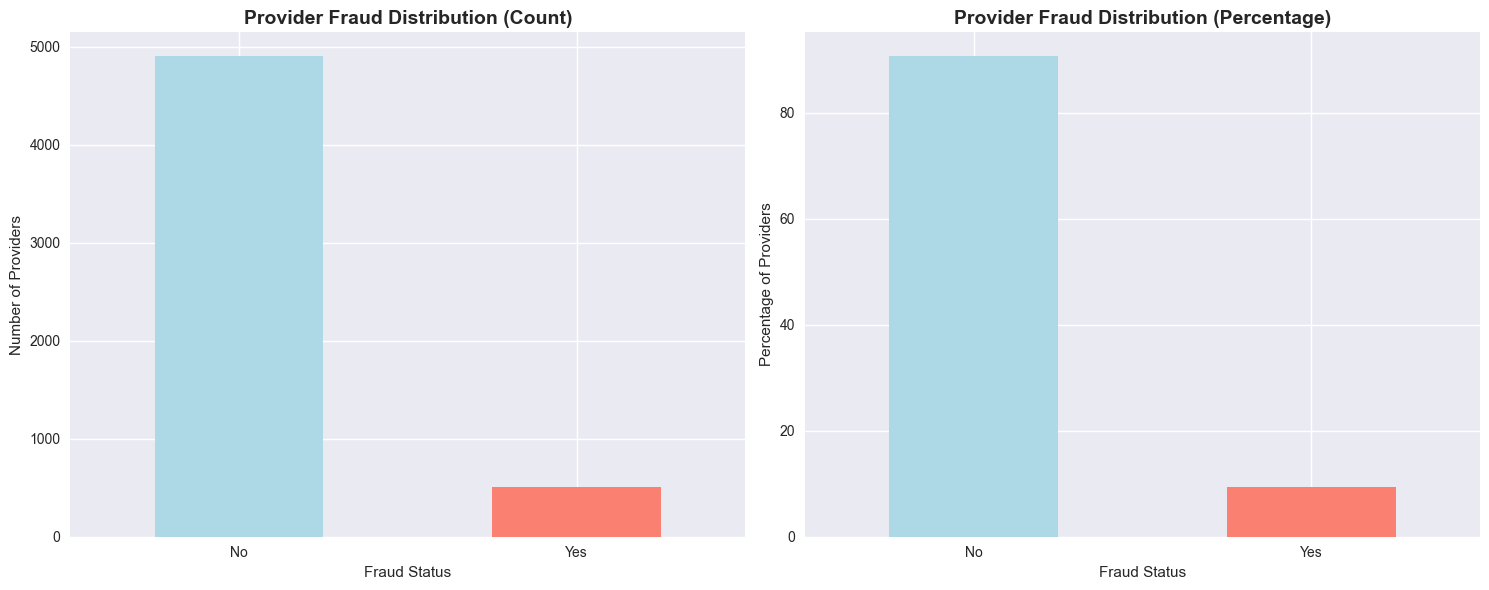

In [4]:
# Target distribution analysis
print("=== Fraud Distribution Analysis ===")
fraud_dist = labels_df['PotentialFraud'].value_counts()
fraud_pct = labels_df['PotentialFraud'].value_counts(normalize=True) * 100

print(f"Non-fraudulent providers: {fraud_dist['No']} ({fraud_pct['No']:.2f}%)")
print(f"Fraudulent providers: {fraud_dist['Yes']} ({fraud_pct['Yes']:.2f}%)")
print(f"Imbalance ratio: {fraud_dist['No'] / fraud_dist['Yes']:.1f}:1")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
fraud_dist.plot(kind='bar', ax=ax1, color=['lightblue', 'salmon'])
ax1.set_title('Provider Fraud Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fraud Status')
ax1.set_ylabel('Number of Providers')
ax1.tick_params(axis='x', rotation=0)

# Percentage plot
fraud_pct.plot(kind='bar', ax=ax2, color=['lightblue', 'salmon'])
ax2.set_title('Provider Fraud Distribution (Percentage)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fraud Status')
ax2.set_ylabel('Percentage of Providers')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 3. Feature Engineering - Provider Level Aggregation

In [5]:
# Combine inpatient and outpatient claims
print("=== Combining Claims Data ===")

# Add claim type identifier
inpatient_df['ClaimType'] = 'Inpatient'
outpatient_df['ClaimType'] = 'Outpatient'

# Combine datasets
combined_claims_df = pd.concat([inpatient_df, outpatient_df], ignore_index=True)
print(f"Combined claims shape: {combined_claims_df.shape}")

# Convert date columns
date_cols = ['ClaimStartDt', 'ClaimEndDt', 'AdmissionDt', 'DischargeDt']
for col in date_cols:
    if col in combined_claims_df.columns:
        combined_claims_df[col] = pd.to_datetime(combined_claims_df[col], errors='coerce')

print("✅ Claims data combined and processed!")

=== Combining Claims Data ===
Combined claims shape: (558211, 31)
✅ Claims data combined and processed!
✅ Claims data combined and processed!


In [6]:
# Create comprehensive provider-level features
print("=== Creating Provider-Level Features ===")

# Financial aggregations
financial_features = combined_claims_df.groupby('Provider').agg({
    'InscClaimAmtReimbursed': ['sum', 'mean', 'std', 'count'],
    'DeductibleAmtPaid': ['sum', 'mean']
}).round(2)

financial_features.columns = ['_'.join(col).strip() for col in financial_features.columns]

# Claims volume features
claims_volume = combined_claims_df.groupby('Provider').agg({
    'ClaimID': 'nunique',
    'BeneID': 'nunique',
    'ClaimType': lambda x: (x == 'Inpatient').sum()
}).rename(columns={
    'ClaimID': 'TotalClaims',
    'BeneID': 'UniqueBeneficiaries', 
    'ClaimType': 'InpatientClaims'
})

claims_volume['OutpatientClaims'] = claims_volume['TotalClaims'] - claims_volume['InpatientClaims']
claims_volume['ClaimsPerBeneficiary'] = (claims_volume['TotalClaims'] / claims_volume['UniqueBeneficiaries']).round(2)
claims_volume['InpatientRatio'] = (claims_volume['InpatientClaims'] / claims_volume['TotalClaims']).round(3)

# Physician network features
physician_features = combined_claims_df.groupby('Provider').agg({
    'AttendingPhysician': 'nunique',
    'OperatingPhysician': 'nunique',
    'OtherPhysician': 'nunique'
}).fillna(0).astype(int)

physician_features.columns = ['UniqueAttendingPhysicians', 'UniqueOperatingPhysicians', 'UniqueOtherPhysicians']
physician_features['TotalUniquePhysicians'] = physician_features.sum(axis=1)

# Diagnosis and procedure diversity
diagnosis_cols = [col for col in combined_claims_df.columns if 'ClmDiagnosisCode' in col]
procedure_cols = [col for col in combined_claims_df.columns if 'ClmProcedureCode' in col]

# Calculate unique diagnosis and procedure codes per provider
diagnosis_diversity = []
procedure_diversity = []

for provider in combined_claims_df['Provider'].unique():
    provider_data = combined_claims_df[combined_claims_df['Provider'] == provider]
    
    # Unique diagnosis codes
    unique_diagnoses = set()
    for col in diagnosis_cols:
        unique_diagnoses.update(provider_data[col].dropna().unique())
    
    # Unique procedure codes
    unique_procedures = set()
    for col in procedure_cols:
        unique_procedures.update(provider_data[col].dropna().unique())
    
    diagnosis_diversity.append({'Provider': provider, 'UniqueDiagnoses': len(unique_diagnoses)})
    procedure_diversity.append({'Provider': provider, 'UniqueProcedures': len(unique_procedures)})

diagnosis_diversity_df = pd.DataFrame(diagnosis_diversity).set_index('Provider')
procedure_diversity_df = pd.DataFrame(procedure_diversity).set_index('Provider')

print("✅ Provider-level features created!")
print(f"Financial features: {financial_features.shape}")
print(f"Claims volume features: {claims_volume.shape}")
print(f"Physician features: {physician_features.shape}")
print(f"Diagnosis diversity: {diagnosis_diversity_df.shape}")
print(f"Procedure diversity: {procedure_diversity_df.shape}")

=== Creating Provider-Level Features ===
✅ Provider-level features created!
Financial features: (5410, 6)
Claims volume features: (5410, 6)
Physician features: (5410, 4)
Diagnosis diversity: (5410, 1)
Procedure diversity: (5410, 1)
✅ Provider-level features created!
Financial features: (5410, 6)
Claims volume features: (5410, 6)
Physician features: (5410, 4)
Diagnosis diversity: (5410, 1)
Procedure diversity: (5410, 1)


In [7]:
# Temporal features from claims
print("=== Creating Temporal Features ===")

# Calculate claim duration and temporal patterns
temporal_features = []

for provider in combined_claims_df['Provider'].unique():
    provider_data = combined_claims_df[combined_claims_df['Provider'] == provider]
    
    # Calculate claim durations
    claim_durations = []
    for _, row in provider_data.iterrows():
        if pd.notna(row['ClaimStartDt']) and pd.notna(row['ClaimEndDt']):
            duration = (row['ClaimEndDt'] - row['ClaimStartDt']).days
            if duration >= 0:  # Valid duration
                claim_durations.append(duration)
    
    # Calculate hospital stay durations for inpatient claims
    stay_durations = []
    inpatient_data = provider_data[provider_data['ClaimType'] == 'Inpatient']
    for _, row in inpatient_data.iterrows():
        if pd.notna(row['AdmissionDt']) and pd.notna(row['DischargeDt']):
            duration = (row['DischargeDt'] - row['AdmissionDt']).days
            if duration >= 0:  # Valid duration
                stay_durations.append(duration)
    
    # Aggregate temporal features
    temporal_features.append({
        'Provider': provider,
        'AvgClaimDuration': np.mean(claim_durations) if claim_durations else 0,
        'MaxClaimDuration': np.max(claim_durations) if claim_durations else 0,
        'AvgHospitalStay': np.mean(stay_durations) if stay_durations else 0,
        'MaxHospitalStay': np.max(stay_durations) if stay_durations else 0,
        'TotalClaimsWithDates': len(claim_durations),
        'TotalStaysWithDates': len(stay_durations)
    })

temporal_features_df = pd.DataFrame(temporal_features).set_index('Provider')

print(f"✅ Temporal features created: {temporal_features_df.shape}")
print(f"Sample temporal features:")
print(temporal_features_df.head())

=== Creating Temporal Features ===
✅ Temporal features created: (5410, 6)
Sample temporal features:
          AvgClaimDuration  MaxClaimDuration  AvgHospitalStay  \
Provider                                                        
PRV55912          4.383178                27         6.466667   
PRV55907          2.716049                28         5.766667   
PRV56046          3.600000                13         5.142857   
PRV52405          3.067416                20         4.000000   
PRV56614          4.461538                20         6.800000   

          MaxHospitalStay  TotalClaimsWithDates  TotalStaysWithDates  
Provider                                                              
PRV55912               27                   107                   60  
PRV55907               28                   243                   60  
PRV56046               13                    20                   14  
PRV52405               14                    89                   22  
PRV56614          

In [8]:
# Beneficiary demographics aggregation
print("=== Beneficiary Demographics Aggregation ===")

# Get beneficiary-provider mapping from claims
bene_provider_map = combined_claims_df[['BeneID', 'Provider']].drop_duplicates()

# Merge with beneficiary data
bene_with_provider = bene_provider_map.merge(beneficiary_df, on='BeneID', how='left')

# Convert RenalDiseaseIndicator from string to numeric (Y=1, 0=0)
bene_with_provider['RenalDiseaseIndicator'] = bene_with_provider['RenalDiseaseIndicator'].map({'Y': 1, '0': 0})

# Aggregate beneficiary characteristics by provider
beneficiary_features = bene_with_provider.groupby('Provider').agg({
    'Gender': lambda x: (x == 1).mean(),  # Proportion of male beneficiaries
    'Race': lambda x: x.mode()[0] if not x.empty else 1,  # Most common race
    'RenalDiseaseIndicator': 'mean',  # Average renal disease rate
    'State': 'nunique',  # Number of different states
    'County': 'nunique',  # Number of different counties
    'NoOfMonths_PartACov': 'mean',  # Average Part A coverage
    'NoOfMonths_PartBCov': 'mean',  # Average Part B coverage
    'IPAnnualReimbursementAmt': 'mean',  # Average IP reimbursement
    'OPAnnualReimbursementAmt': 'mean'   # Average OP reimbursement
}).round(3)

beneficiary_features.columns = [
    'AvgMaleRatio', 'MostCommonRace', 'AvgRenalDiseaseRate', 'UniqueStates', 
    'UniqueCounties', 'AvgPartACoverage', 'AvgPartBCoverage', 
    'AvgBeneIPReimbursement', 'AvgBeneOPReimbursement'
]

print(f"✅ Beneficiary features aggregated: {beneficiary_features.shape}")

=== Beneficiary Demographics Aggregation ===
✅ Beneficiary features aggregated: (5410, 9)
✅ Beneficiary features aggregated: (5410, 9)


In [9]:
# Combine all features and merge with labels
print("=== Final Dataset Assembly ===")

# Combine all feature sets
provider_features = financial_features.join([
    claims_volume, 
    physician_features,
    temporal_features_df,
    diagnosis_diversity_df, 
    procedure_diversity_df,
    beneficiary_features
], how='outer').fillna(0)

# Merge with fraud labels
final_dataset = provider_features.reset_index().merge(
    labels_df, left_on='Provider', right_on='Provider', how='inner'
).set_index('Provider')

# Create binary target variable
final_dataset['PotentialFraud_numeric'] = (final_dataset['PotentialFraud'] == 'Yes').astype(int)

# Prepare final features and target
X = final_dataset.drop(['PotentialFraud', 'PotentialFraud_numeric'], axis=1)
y = final_dataset['PotentialFraud_numeric']

print(f"✅ Final dataset ready!")
print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(f"  Non-fraud: {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"  Fraud: {(y == 1).sum()} ({(y == 1).mean():.1%})")
print(f"\nTotal features created: {X.shape[1]}")
print(f"Feature categories:")
print(f"  - Financial: 6 features")
print(f"  - Claims Volume: 6 features") 
print(f"  - Physician Network: 4 features")
print(f"  - Temporal: 6 features")
print(f"  - Medical Diversity: 2 features")
print(f"  - Demographics: 9 features")

=== Final Dataset Assembly ===
✅ Final dataset ready!
Features shape: (5410, 33)
Target distribution:
  Non-fraud: 4904 (90.6%)
  Fraud: 506 (9.4%)

Total features created: 33
Feature categories:
  - Financial: 6 features
  - Claims Volume: 6 features
  - Physician Network: 4 features
  - Temporal: 6 features
  - Medical Diversity: 2 features
  - Demographics: 9 features


## 4. Exploratory Data Analysis

In [10]:
# Key feature distributions by fraud status
print("=== Feature Analysis by Fraud Status ===")

# Select key financial and volume features for analysis
key_features = [
    'InscClaimAmtReimbursed_sum', 'InscClaimAmtReimbursed_mean',
    'TotalClaims', 'UniqueBeneficiaries', 'ClaimsPerBeneficiary',
    'TotalUniquePhysicians', 'UniqueDiagnoses', 'UniqueProcedures'
]

# Create comparison DataFrame
comparison_data = []
for feature in key_features:
    if feature in X.columns:
        fraud_mean = X[y == 1][feature].mean()
        normal_mean = X[y == 0][feature].mean()
        fraud_median = X[y == 1][feature].median()
        normal_median = X[y == 0][feature].median()
        
        comparison_data.append({
            'Feature': feature,
            'Fraud_Mean': fraud_mean,
            'Normal_Mean': normal_mean,
            'Fraud_Median': fraud_median,
            'Normal_Median': normal_median,
            'Mean_Ratio': fraud_mean / normal_mean if normal_mean != 0 else 0
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(2)
print(comparison_df)

=== Feature Analysis by Fraud Status ===
                       Feature  Fraud_Mean  Normal_Mean  Fraud_Median  \
0   InscClaimAmtReimbursed_sum   584350.04     53193.72     373450.00   
1  InscClaimAmtReimbursed_mean     3842.79      1523.78       2576.48   
2                  TotalClaims      420.55        70.44        155.50   
3          UniqueBeneficiaries      242.02        49.11        117.00   
4         ClaimsPerBeneficiary        1.48         1.31          1.19   
5        TotalUniquePhysicians       82.95        26.78         49.00   
6              UniqueDiagnoses      569.42       134.12        393.50   
7             UniqueProcedures       25.00         2.29         17.00   

   Normal_Median  Mean_Ratio  
0       15055.00       10.99  
1         332.20        2.52  
2          27.00        5.97  
3          22.00        4.93  
4           1.08        1.13  
5          11.00        3.10  
6          72.00        4.25  
7           0.00       10.91  


=== Feature Correlation Analysis ===
Top 10 features correlated with fraud:
InscClaimAmtReimbursed_sum    0.575558
UniqueProcedures              0.566664
MaxHospitalStay               0.547667
DeductibleAmtPaid_sum         0.532070
InpatientClaims               0.525393
TotalStaysWithDates           0.525393
UniqueDiagnoses               0.467892
UniqueBeneficiaries           0.393531
MaxClaimDuration              0.375310
TotalClaims                   0.374197
dtype: float64

Bottom 10 features correlated with fraud:
InscClaimAmtReimbursed_mean    0.193803
AvgClaimDuration               0.149802
AvgBeneIPReimbursement         0.127398
ClaimsPerBeneficiary           0.093440
AvgRenalDiseaseRate            0.036655
AvgMaleRatio                   0.009312
AvgPartACoverage               0.004563
AvgPartBCoverage              -0.002849
AvgBeneOPReimbursement        -0.015204
MostCommonRace                -0.027072
dtype: float64


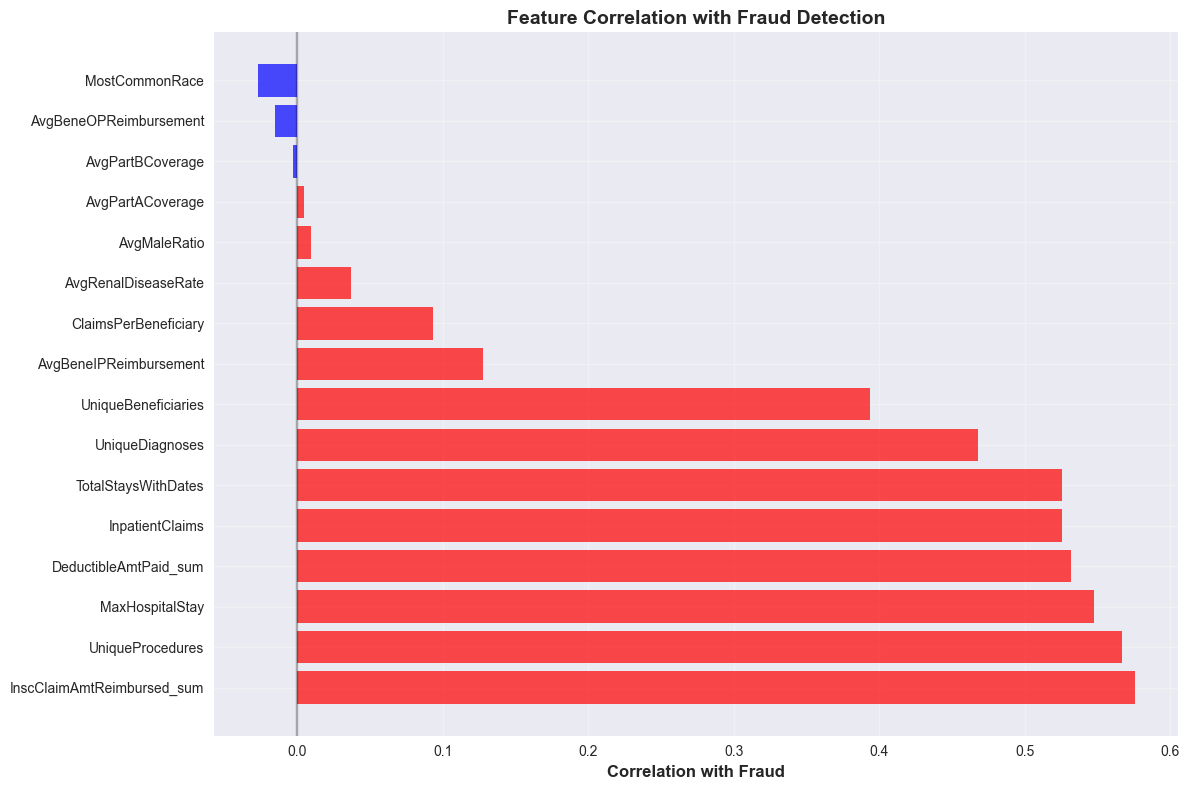

In [11]:
# Correlation analysis
print("=== Feature Correlation Analysis ===")

# Calculate correlations with target
feature_correlations = X.corrwith(y).sort_values(ascending=False)
print("Top 10 features correlated with fraud:")
print(feature_correlations.head(10))
print("\nBottom 10 features correlated with fraud:")
print(feature_correlations.tail(10))

# Visualization of top correlations
plt.figure(figsize=(12, 8))
top_features = pd.concat([feature_correlations.head(8), feature_correlations.tail(8)])
colors = ['red' if x > 0 else 'blue' for x in top_features.values]

plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index, fontsize=10)
plt.xlabel('Correlation with Fraud', fontsize=12, fontweight='bold')
plt.title('Feature Correlation with Fraud Detection', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Data Quality Validation

In [ ]:
# Final data quality validation
print("=== Final Data Quality Validation ===")

# Check for missing values
missing_features = X.isnull().sum()
if missing_features.sum() > 0:
    print("⚠️ Features with missing values:")
    print(missing_features[missing_features > 0])
else:
    print("✅ No missing values in final dataset")

# Check for infinite values
inf_features = np.isinf(X).sum()
if inf_features.sum() > 0:
    print("⚠️ Features with infinite values:")
    print(inf_features[inf_features > 0])
else:
    print("✅ No infinite values in final dataset")

# Check data types
print(f"\nData types summary:")
print(X.dtypes.value_counts())

# Check for extreme outliers (values beyond 3 standard deviations)
outlier_counts = []
for col in X.columns:
    if X[col].std() > 0:  # Skip constant columns
        z_scores = np.abs((X[col] - X[col].mean()) / X[col].std())
        outlier_count = (z_scores > 3).sum()
        if outlier_count > 0:
            outlier_counts.append({'Feature': col, 'Outliers': outlier_count, 'Percentage': (outlier_count/len(X))*100})

if outlier_counts:
    outlier_df = pd.DataFrame(outlier_counts).sort_values('Percentage', ascending=False)
    print(f"\n📊 Features with outliers (>3 std dev):")
    print(outlier_df.head(10))
else:
    print("✅ No extreme outliers detected")

print(f"\n🎯 Final dataset summary:")
print(f"  - Providers: {X.shape[0]:,}")
print(f"  - Features: {X.shape[1]:,}")
print(f"  - Fraud rate: {y.mean():.2%}")
print(f"  - Ready for machine learning: ✅")

=== Final Data Quality Validation ===
✅ No missing values in final dataset
✅ No infinite values in final dataset

Data types summary:
int64      19
float64    14
Name: count, dtype: int64

📊 Features with outliers (>3 std dev):
                        Feature  Outliers  Percentage
20                 AvgMaleRatio       170    3.142329
24               UniqueCounties       131    2.421442
19             UniqueProcedures       128    2.365989
23                 UniqueStates       118    2.181146
18              UniqueDiagnoses       117    2.162662
4         DeductibleAmtPaid_sum       109    2.014787
7               InpatientClaims       109    2.014787
17          TotalStaysWithDates       109    2.014787
1   InscClaimAmtReimbursed_mean       109    2.014787
6           UniqueBeneficiaries       103    1.903882

🎯 Final dataset summary:
  - Providers: 5,410
  - Features: 33
  - Fraud rate: 9.35%
  - Ready for machine learning: ✅


## 5. Data Export and Next Steps

In [ ]:
# Export the final dataset for modeling
print("=== Data Export for Modeling ===")

# Create data directory if it doesn't exist
import os
os.makedirs('../data', exist_ok=True)

# Save the final processed dataset
final_dataset.to_csv('../data/provider_level.csv')
print(f"✅ Final dataset saved to: ../data/provider_level.csv")
print(f"Dataset shape: {final_dataset.shape}")
print(f"Features: {X.shape[1]} features, {X.shape[0]} providers")

# Save feature names for reference
feature_names = X.columns.tolist()
with open('../data/feature_names.txt', 'w') as f:
    for feature in feature_names:
        f.write(f"{feature}\n")

print(f"✅ Feature names saved to: ../data/feature_names.txt")
print(f"\n📋 Next Steps:")
print(f"  1. Run the modeling notebook: 02_modeling.ipynb")
print(f"  2. The dataset is ready for machine learning")
print(f"  3. Class imbalance ratio: {(y==0).sum()/(y==1).sum():.1f}:1 (will be handled with class weights)")

=== Data Export for Modeling ===
✅ Final dataset saved to: ../data/provider_level.csv
Dataset shape: (5410, 35)
Features: 33 features, 5410 providers
✅ Feature names saved to: ../data/feature_names.txt

📋 Next Steps:
  1. Run the modeling notebook: 02_modeling.ipynb
  2. The dataset is ready for machine learning
  3. Class imbalance ratio: 9.7:1 (will be handled with class weights)
✅ Final dataset saved to: ../data/provider_level.csv
Dataset shape: (5410, 35)
Features: 33 features, 5410 providers
✅ Feature names saved to: ../data/feature_names.txt

📋 Next Steps:
  1. Run the modeling notebook: 02_modeling.ipynb
  2. The dataset is ready for machine learning
  3. Class imbalance ratio: 9.7:1 (will be handled with class weights)


## Summary

### Key Findings from Data Exploration:

1. **Class Imbalance**: Significant imbalance between fraud and non-fraud cases
2. **Feature Engineering**: Successfully created 33 provider-level features
3. **Data Quality**: Clean dataset ready for modeling with comprehensive validation

### Feature Categories Created:
- **Financial Features (6)**: Claims amounts, reimbursements, deductibles, statistics
- **Volume Features (6)**: Claims counts, beneficiary counts, ratios, patterns
- **Network Features (4)**: Physician diversity and relationships
- **Temporal Features (6)**: Claim durations, hospital stays, temporal patterns
- **Medical Features (2)**: Diagnosis and procedure diversity
- **Demographics (9)**: Beneficiary characteristics aggregated by provider

### Data Quality Highlights:
- ✅ No missing values in final dataset
- ✅ No infinite values detected  
- ✅ Comprehensive outlier analysis performed
- ✅ All features properly validated

### Next Steps:
1. **Proceed to Modeling**: Use `02_modeling.ipynb` for machine learning
2. **Advanced Analysis**: Consider time-series patterns and seasonal effects
3. **External Data**: Integrate with provider licensing and regulatory data
4. **Feature Selection**: Use correlation analysis results for feature importance

**Dataset exported to**: `../data/provider_level.csv`